# Breast Cancer Detection Demo
## Brenna Gibbons

### The problem:
Breast cancer detection is expensive both in terms of time and money. We'd like to reduce the number of tests required to accurately detect malignancy using a model based on past patients' data.

### The data:
A text file with 12 comma separated values: index, patient ID, 9 features, and a 'Class' which can be 2 for benign or 4 for malignant.

### The approach:
Prototype an iterative process for cancer detection, where more tests are conducted only if the previous tests were inconclusive. This system was built on a series of random forest classifiers but is robust to the insertion of other types of classifiers.

This notebook presents a proof-of-concept that such an iterative process would yield similar results to doing the full model every time. The way I picture this working is that a physician or technician at a microscope would measure the first n features, input them into a dashboard, and recieve a real-time suggestion of whether or not to collect more data on this sample. More data would be collected only if the model's prediction on the first n features was inconclusive.

### Results:
Recall was chosen as the most relevant metric, as it is typically worse to miss a case of disease than to give a false positive (though obviously neither is ideal). The full model achieved a recall of 96.1% on cross validation and 95.8% on a holdout test set, while the iterative version also achieved a test set recall of 95.8% with a cost savings of more than 50%. Using the iterative system would save physicians time and effort with minimal if any loss of performance.
***
***

#### Housekeeping

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

### Import data

In [4]:
# import and peek at data
data_str = pd.read_csv('breast-cancer-wisconsin.txt')
data_str.head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


#### Data cleanup: 
Convert to numbers, remove any rows containing non-numbers (e.g. a cell size of 'no idea'), and remove any classes that aren't 2 or 4. We'll also convert the class labels to binary 0 or 1.
In addition, we'll remove duplicate lines (every column in each row must be identical, not just ID).

In [5]:
# convert to numbers
data = data_str.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

# get indices of all rows with NaN
nans = np.unique(np.where(np.isnan(data))[0])
nan_ids = data['ID'][nans]
print("Found {} rows with non-number values. \n \
Removing them from data. To get ID values: print(nan_ids)".format(len(nan_ids)))

# now remove all rows with NaN
data.dropna(axis = 0, how = 'any', inplace = True)
data.drop(columns='Index', inplace = True)

# remove rows with bad class values
bad_class = data[(data['Class'] != 2) & (data['Class'] != 4)]
len(bad_class)
print('Removing {} rows with a Class value not equal to 2 or 4.'.format(len(bad_class)))
data.drop(bad_class.index, inplace = True)

# replace 2 and 4 with 0 and 1 where 0 = benign and 1 = malignant
data.loc[data['Class'] == 2, 'Class'] = 0
data.loc[data['Class'] == 4, 'Class'] = 1

# drop duplicates
data = data.drop_duplicates(inplace=False)
print('Duplicates removed')

Found 95 rows with non-number values. 
 Removing them from data. To get ID values: print(nan_ids)
Removing 156 rows with a Class value not equal to 2 or 4.
Duplicates removed


### Data Exploration

This dataset contains 437 benign and 235 malignant samples.


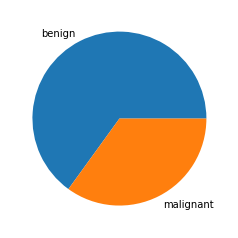

In [6]:
# Look at the relative sizes of the classes
num_benign = len(data[data['Class'] == 0])
num_mal = len(data[data['Class'] == 1])
total = len(data)
print('This dataset contains {} benign and {} malignant samples.'.format(num_benign, num_mal))
pieplot = plt.pie([num_benign/total,num_mal/total],labels = ['benign','malignant'])

Because the data is somewhat imbalanced, we'll have to be careful from here on out.

### Feature exploration
To answer the question of which features of the cell are the largest drivers of malignancy, we'll look at the Pearson correlation of each input feature with the resulting diagnosis:

Pearson Correlations with diagnosis:
Uniformity of Cell Size        0.820048
Bare Nuclei                    0.819718
Bland Chromatin                0.757816
Clump Thickness                0.715084
Uniformity of Cell Shape       0.820085
Marginal Adhesion              0.709798
Single Epithelial Cell Size    0.688764
Mitoses                        0.425387
Normal Nucleoli                0.720845
Name: Class, dtype: float64


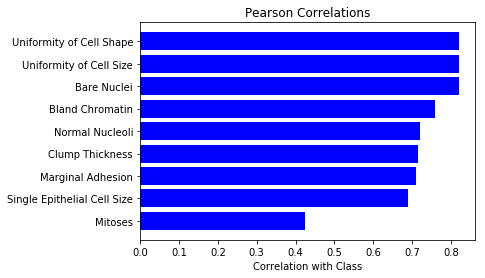

In [7]:
# compute correlations
class_corr = data.corr(method = 'pearson')['Class']
# drop ID, Class columns
class_corr = class_corr.drop(index=['Class','ID'])
class_corr_idx = np.argsort(np.abs(class_corr))
print('Pearson Correlations with diagnosis:')
print(class_corr.iloc[-class_corr_idx])

# and plot
plt.title('Pearson Correlations')
plt.barh(range(len(class_corr_idx)), class_corr[class_corr_idx], color='b', align='center')
plt.yticks(range(len(class_corr_idx)), [class_corr.index[i] for i in class_corr_idx])
plt.xlabel('Correlation with Class')
plt.show()

Let's look closer at the most correlated feature to see if we could just diagnose based on it alone:

Text(0, 0.5, 'Proportion of cases which are malignant')

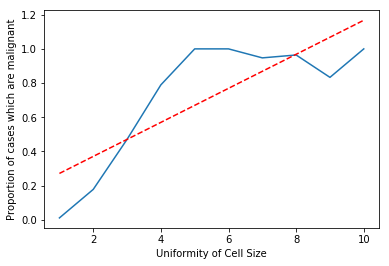

In [8]:
# quick and dirty correlation exploration:
x = [l+1 for l in range(10)]
y = []
total = len(data)
for i in range(10):
    num_pos = len(data.index[(data['Uniformity of Cell Size'] == i+1) &(data['Class'] == 1)])
    num_tot = len(data.index[(data['Uniformity of Cell Size'] == i+1)])
    y.append(num_pos/num_tot)

u_size = plt.plot(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.xlabel('Uniformity of Cell Size')
plt.ylabel('Proportion of cases which are malignant')

## Analysis
Let's compare the base model and the iterative one. We'll start with the base model.

First some housekeeping: split the data into test/train and set up metrics and a cross-validation splitter, all keeping in mind the unbalanced classes.

In [9]:
# set up which columns will be features
data.columns
input_cols = ['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']

# double check column names are all there and correct
if not (x in data.columns for x in input_cols):
    print("Column names don't match, this is not going to work!")

In [16]:
# split the data into test and train, keeping proportion of "benign" equal
# split off true test set with class distribution equal to original
X_all = data[input_cols]
y_all = data['Class']
X, X_test, y, y_test = train_test_split(X_all, y_all, 
                                        test_size=0.1,
                                        random_state=6,
                                        stratify=y_all, # use class labels to stratify
                                        shuffle=True)

# set up 
metrics = ['f1','f1_weighted','recall','recall_weighted','neg_log_loss','roc_auc']
splitter = StratifiedKFold(n_splits=5, random_state = 6, shuffle=True)

#### Base Model: Random Forest

In [17]:
# remember that the classes are imbalanced, so we'll weight them
clf = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
# cross validation
cv_results = cross_validate(clf, X, y, 
                            cv=splitter, 
                            return_train_score=False, 
                            scoring=metrics)
cv_means = {k: np.mean(v) for k,v in cv_results.items()}
cv_means

{'fit_time': 0.08330078125,
 'score_time': 0.0237123966217041,
 'test_f1': 0.957188359348725,
 'test_f1_weighted': 0.9701558962558503,
 'test_recall': 0.9619047619047618,
 'test_recall_weighted': 0.9701515151515151,
 'test_neg_log_loss': -0.14702291810958967,
 'test_roc_auc': 0.9912702276626326}

#### Validation: 
Recall of 96.1% is pretty good! Let's try the true test set:

In [39]:
# fit to all training data
clf.fit(X,y)
y_pred = clf.predict(X_test)
# test
rf_recall = recall_score(y_test,y_pred)
print('Holdout Test Set Recall = {:0.2f}%'.format(rf_recall*100))

Holdout Test Set Recall = 95.83%


Let's plot the confusion matrix to get more specifics:

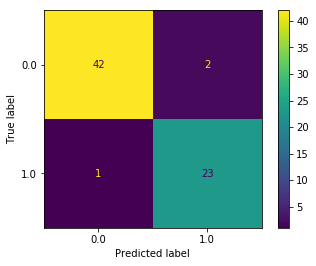

In [19]:
# plot confusion matrix on test set
plot_confusion_matrix(clf,X_test,y_test)

Only 1 false negative!

#### Feature Importance
As a sanity check, we'll compare the feature importance here to the correlations above. It's pretty similar!

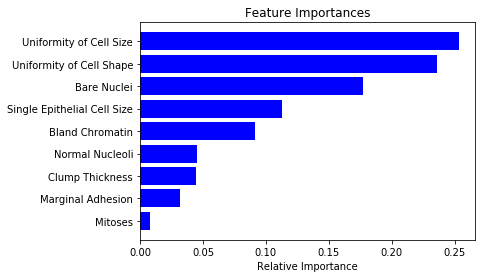

In [20]:
# get importances
importances = clf.feature_importances_
imp_indices = np.argsort(importances)
# and plot
plt.title('Feature Importances')
plt.barh(range(len(imp_indices)), importances[imp_indices], color='b', align='center')
plt.yticks(range(len(imp_indices)), [input_cols[i] for i in imp_indices])
plt.xlabel('Relative Importance')
plt.show()

#### Most informative features
The fact that the top 3 features from the random forest are also the top 3 features from the Pearson correlation isn't surprising, but it does add confidence that these features are in fact the most predictive for breast cancer detection.

### Iterative Testing
Now we'll set up the system for doing further tests only if the first ones are unsure. For this example, we'll assume each test on each sample costs $1.

In practice, this would be a dashboard where the physician could enter the test values, get a prediction for how likely this sample is to be malignant or not, and use that to decide to do more tests and feed those back into a more sophisticated model.

In [28]:
def progressive_predict(classifiers, test_data, epsilon = 0.1):
    """
    Predict malignant/benign given input data, and calculate number of tests required
    Parameters:
    classifiers (list) : progressively more costly classifiers (must be in order)
                         must be of form (clf, [features])
    test_data (dataframe) : must contain 'Class' = 0 or 1, 
                            and feature columns: 'Clump Thickness','Uniformity of Cell Size',
                                                 'Uniformity of Cell Shape','Marginal Adhesion',
                                                 'Single Epithelial Cell Size','Bare Nuclei',
                                                 'Bland Chromatin','Normal Nucleoli','Mitoses'
    Returns:
    predictions : benign/malignant for test_data
    cost: number of tests that had to be performed
    """
    # at the beginning, all are schrodinger's cat
    dunnos = np.ones_like(test_data['Mitoses'])*0.5
    preds = pd.DataFrame({'Prediction':dunnos}, index = test_data.index)
    num_tests = 0
    prev_features = 0
    
    # loop through each progressively heavier classifier
    for clf, features in classifiers:
        # get unsure values
        unsure_idx = preds.index[(preds['Prediction'] > epsilon) & (preds['Prediction'] < 1-epsilon)]
        print('{} unsure'.format(len(unsure_idx)))
        # print(features)
        # make predictions only on unsure
        probs = clf.predict_proba(test_data[features].loc[unsure_idx])
        # store in outer dataframe
        preds['Prediction'].loc[unsure_idx] = probs[:,1]
        
        # add cost = number of features(tests) * number of new predictions
        new_tests = (len(features)-prev_features) * len(unsure_idx)
        print('{} new tests'.format(new_tests))
        num_tests += new_tests
        prev_features = len(features)
    
    return preds, num_tests

Set up our series of models:

In [44]:
# set up random forest series of classifiers
# least strict (first 3 features)
features1 = ['Uniformity of Cell Size','Uniformity of Cell Shape','Bare Nuclei']
# print(features1)
rf_clf1 = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
rf_clf1.fit(X[features1],y)
rf1_recall = recall_score(y_test,rf_clf1.predict(X_test[features1]))
# print('Recall using 3 features = {:0.2f}%'.format(rf1_recall*100))

# next strictest
features2 = features1 + ['Single Epithelial Cell Size','Clump Thickness','Marginal Adhesion']
# print(features2)
rf_clf2 = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
rf_clf2.fit(X[features2],y)
rf2_recall = recall_score(y_test,rf_clf2.predict(X_test[features2]))
# print('Recall using 6 features = {:0.2f}%'.format(rf2_recall*100))

# strictest
features3 = features2 + ['Normal Nucleoli','Bland Chromatin','Mitoses']
# print(features3)
rf_clf3 = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
rf_clf3.fit(X[features3],y)
rf3_recall = recall_score(y_test,rf_clf3.predict(X_test[features3]))
# print('Recall using 9 features = {:0.2f}%'.format(rf3_recall*100))

# list them:
classifiers = [(rf_clf1,features1),(rf_clf2,features2),(rf_clf3,features3)]

Now to calculate the final predictions using this system and calculate the number of tests required, using the holdout test set:

In [29]:
ps,cost = progressive_predict(classifiers, X_test, epsilon = 0.01)

68 unsure
204 new tests
17 unsure
51 new tests
12 unsure
36 new tests


#### Validation: 
We'll look at both recall and cost

In [38]:
# to fudge the threshold, do ps + epsilon
pclasses = round(ps)
it_recall = recall_score(y_test,pclasses)
print('Holdout Test Set Recall = {:0.2f}%'.format(it_recall*100))

Holdout Test Set Recall = 95.83%


Recall of 95.8% !

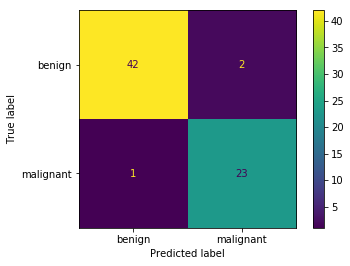

In [31]:
# plot confusion matrix
cm = confusion_matrix(y_test,pclasses)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant'])
disp = disp.plot()

Now compare the performance and costs:

(0.8, 1)

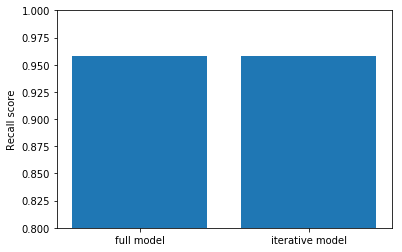

In [45]:
# compare recall scores
cost_plot = plt.bar(x = [1,2],height=[rf_recall,it_recall],tick_label = ['full model','iterative model'])
plt.ylabel('Recall score')
plt.ylim(0.8,1)

Cost savings: 52.5%


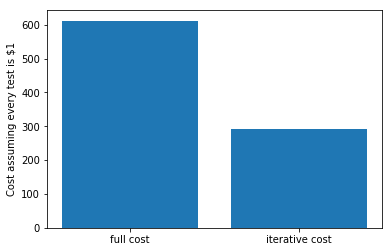

In [46]:
full_cost = len(y_test)*len(input_cols)
cost_plot = plt.bar(x = [1,2],height=[full_cost,cost],tick_label = ['full cost','iterative cost'])
plt.ylabel('Cost assuming every test is $1')
print('Cost savings: {:.1f}%'.format(100*(full_cost-cost)/full_cost))

## Results

Takeaways: The original and iterative models were nearly identical in their performance, with recall rates of 90+%. However, the iterative model cost approximately 50% less than the original model would. Using the iterative model would save not only cost but physician's valuable time - with this model they can devote more time to cases that are more difficult to diagnose or to actually treating patients.

Furthermore, the iterative model can be used with other classifiers and with more granular control. Optimizing the models further through hyperparameter tuning, etc, would be an excellent future direction.

## Appendix

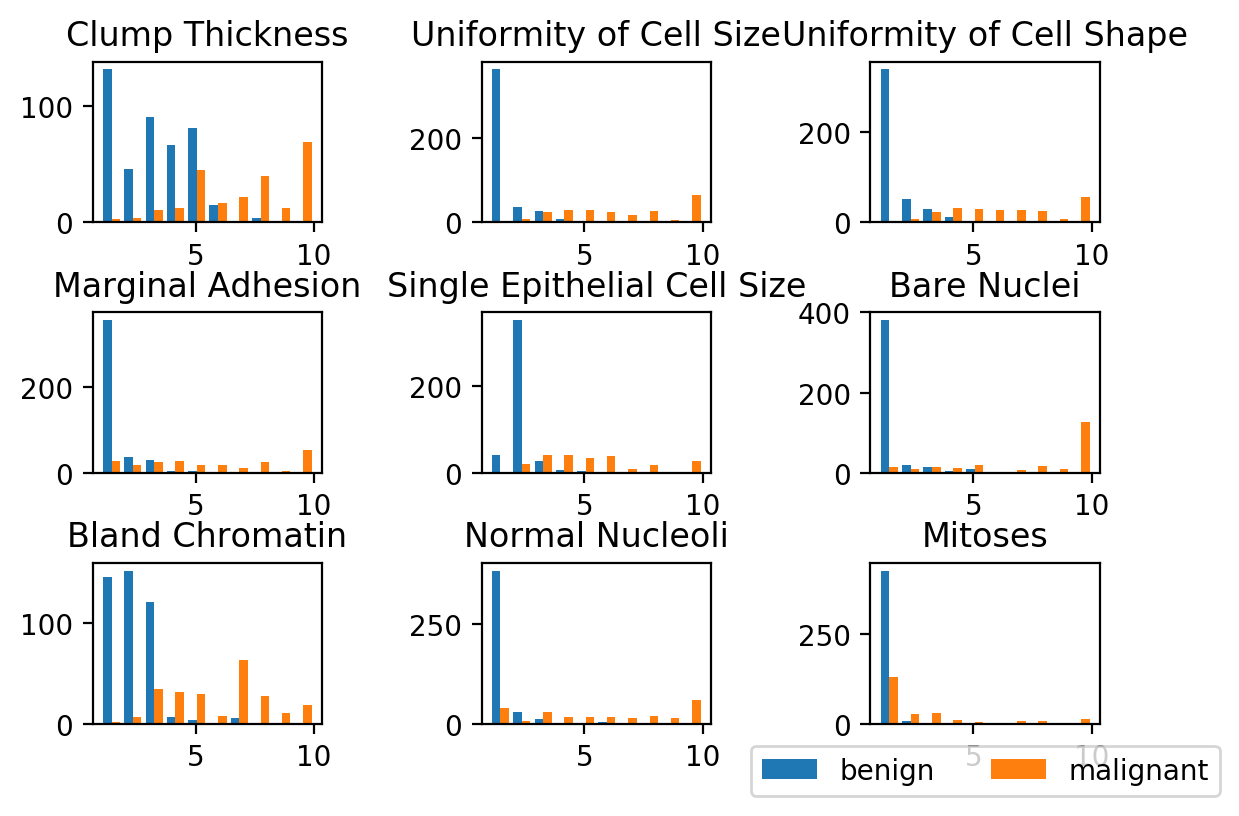

<Figure size 2400x1600 with 0 Axes>

In [76]:
# define columns that are inputs instead of classes
input_cols = ['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']

# double check column names are all there and correct
if not (x in data.columns for x in input_cols):
    print("Column names don't match, this is not going to work!")
    
# plot histograms
plt.rcParams['figure.dpi'] = 200
for num, colname in enumerate(input_cols):
    plt.subplot(3, 3, num+1)
    plt.hist((data[data['Class'] == 0][colname], data[data['Class'] == 1][colname]), bins=10, label=['benign', 'malignant'])
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=2)
    plt.title(colname)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=2)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0)
plt.figure(figsize=(12,8))
plt.show()

### MLP
MultiLayerPerceptron works just as well, it's just a little harder to interpret:

In [34]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes = 200)
# cross validation using recall
cv_results = cross_validate(mlp_clf, X, y, 
                            cv=splitter, 
                            return_train_score=False, 
                            scoring=metrics)
cv_means = {k: np.mean(v) for k,v in cv_results.items()}
cv_means

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'fit_time': 0.6652781963348389,
 'score_time': 0.010382366180419923,
 'test_f1': 0.9526435554369224,
 'test_f1_weighted': 0.9668698377784587,
 'test_recall': 0.9573643410852715,
 'test_recall_weighted': 0.9668595041322314,
 'test_neg_log_loss': -0.0904245763862684,
 'test_roc_auc': 0.9947355330045939}

0.92


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


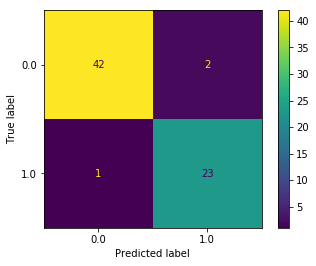

In [35]:
# try holdout test set
mlp_clf.fit(X,y)
y_pred = mlp_clf.predict(X_test)
mlp_recall = recall_score(y_pred,y_test)
print(mlp_recall)

# plot confusion matrix on test set
plot_confusion_matrix(mlp_clf,X_test,y_test)

### Hyperparameter tuning
Use log-loss for scoring to minimize confident wrong predictions

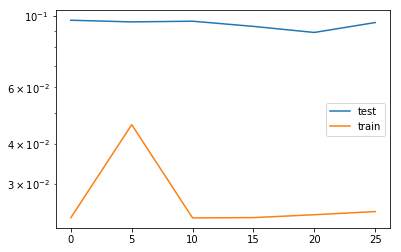

In [36]:
parameters = {'max_depth':(None, 5,10,15,20,25)}

# set up grid search
tuner = GridSearchCV(clf, parameters, 
                     scoring = 'neg_log_loss',
                     return_train_score = True, 
                     cv = splitter)
tuner.fit(X,y)
# show results
tuner_results = pd.DataFrame(tuner.cv_results_)
tuner_results.head()

# and plot
plt.semilogy([0,5,10,15,20,25], -1*tuner_results['mean_test_score'],label = 'test')
plt.semilogy([0,5,10,15,20,25], -1*tuner_results['mean_train_score'],label = 'train')
plt.legend()